In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import skimage
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D
import skimage.io as io

import numpy as np
from skimage import morphology, io
from scipy.ndimage import binary_dilation, binary_erosion
from joblib import Parallel, delayed


np.random.seed(6)
lbl_cmap = random_label_cmap()
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [ ]:
# fast dilation erosion
def add_protective_round(array, border_size):
    # Calculate the new dimensions for the protective round
    new_shape = tuple(np.array(array.shape) + 2 * border_size)

    # Create a new array with zeros and the new dimensions
    protected_array = np.zeros(new_shape, dtype=array.dtype)

    # Copy the original array into the new array, leaving a border of zeros
    protected_array[border_size:-border_size, border_size:-border_size, border_size:-border_size] = array

    return protected_array


def remove_protective_round(protected_array, border_size):
    # Extract the central region of the array, excluding the protective round border
    processed_array = protected_array[border_size:-border_size, border_size:-border_size, border_size:-border_size]

    return processed_array


def process_label(image, label, selem, iterations, border_size):
    # Find the indices of the label in the array
    indices = np.argwhere(image == label)

    # Determine the bounding box of the region
    min_z, min_y, min_x = np.min(indices, axis=0)
    max_z, max_y, max_x = np.max(indices, axis=0)

    # Crop the array to include only the region of interest
    cropped_binary_array = image[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1] == label
    protected_array = add_protective_round(cropped_binary_array, border_size=border_size)

    # Perform dilation and erosion on the cropped region
    dilated_region = binary_dilation(protected_array, iterations=iterations, structure=selem)
    eroded_region = binary_erosion(dilated_region, iterations=iterations, structure=selem)
    remove_protect_array = remove_protective_round(eroded_region, border_size=border_size)
    print(label)
    return (label, (min_z, max_z, min_y, max_y, min_x, max_x), remove_protect_array)


def perform_dilation_erosion(image, kernel_size=9, iterations=1, border_size=10):
    # Initialize an empty result array
    result = np.zeros_like(image)

    unique_labels = np.unique(image)

    print('total_round:', len(unique_labels))

    selem = morphology.ball(kernel_size)
    # Perform processing in parallel
    processed_regions = Parallel(n_jobs=-1)(
        delayed(process_label)(image, label, selem, iterations, border_size)
        for label in unique_labels if label != 0
    )

    # Update the result array with the processed regions
    for label, (min_z, max_z, min_y, max_y, min_x, max_x), remove_protect_array in processed_regions:
        result[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1][remove_protect_array] = label

    return result

In [19]:
# split, prediction and merge
def merge_overlap(
    image,
    labels,
    x_pos,
    x_num,
    x_st,
    cut_x,
    y_pos,
    y_num,
    y_st,
    cut_y,
    centroids,
    half_overlap_size,
):

    x_left_border = x_st if x_pos == 0 else x_st + half_overlap_size
    x_right_border = x_st + cut_x if x_pos == x_num - 1 else  x_st + cut_x - half_overlap_size
    y_left_border = y_st if y_pos == 0 else y_st + half_overlap_size
    y_right_border = y_st + cut_y if y_pos == y_num - 1 else  y_st + cut_y - half_overlap_size

    image[
        :,
        x_left_border : x_right_border,
        y_left_border : y_right_border
    ] = labels[
        :,
        x_left_border - x_st : x_right_border - x_st,
        y_left_border - y_st : y_right_border - y_st: 
    ]
    
    for z in range(image.shape[0]):
        for x in range(x_left_border, x_right_border):
            pre_label = image[z, x, y_left_border - 1]
            post_label = image[z, x, y_left_border]
            if pre_label != 0 and post_label != 0 and pre_label != post_label:
                image[image == post_label] = pre_label

        for y in range(y_left_border, y_right_border + cut_y):
            pre_label = image[z, x_left_border - 1, y]
            post_label = image[z, x_left_border, y]
            if pre_label != 0 and post_label != 0 and pre_label != post_label:
                image[image == post_label] = pre_label
        

    included_centroids = []
    for point in centroids:
        z, x, y = point

        # Check if the point is within the specified range
        if (
            half_overlap_size * x_left_border
            <= x
            < cut_x - half_overlap_size * x_right_border
            and half_overlap_size * y_left_border
            <= y
            < cut_y - half_overlap_size * y_right_border
        ):
            # Add the point to the filtered list
            included_centroids.append(point)

    return image, included_centroids


def divide_and_reconstract(model, image, great_number=1000, overlap_size=50):
    axis_norm = (0,1,2)
    img = normalize(image, 1, 99.8, axis=axis_norm)
    full = np.empty_like(image, dtype=np.int16)

    centroid = []

    x_num = -(-(image.shape[1] - overlap_size) // (512 - overlap_size))
    y_num = -(-(image.shape[2] - overlap_size) // (512 - overlap_size))

    print(x_num, y_num)

    cut_x = image.shape[1] // x_num + overlap_size
    cut_y = image.shape[2] // y_num + overlap_size

    print(cut_x, cut_y)
    
    pad_width = [(0, 0), (1, 0), (1, 0)]
    full = np.pad(full, pad_width, constant_values=0)
    
    x_st = 1
    y_st = 1
    x_step = cut_x - overlap_size
    y_step = cut_y - overlap_size

    print(x_step, y_step)

    for x_pos in range(x_num):
        for y_pos in range(y_num):
            cut = img[
                :,
                x_st : x_st + cut_x,
                y_st : y_st + cut_y,
            ]

            labels, details = model.predict_instances(cut)
            num = x_pos * x_num + y_pos

            io.imsave('./data/ctx_dapi/test/images/temp'+str(num)+'.tif',labels)

            labels += num * great_number
            labels[labels == num * great_number] = 0

            cut_centroids = [_ + np.array([0, x_st, y_st]) for _ in details["points"]]

            half_overlap_size = overlap_size // 2
            full, label_centroid = merge_overlap(
                full,
                labels,
                x_pos,
                x_num,
                x_st,
                cut_x,
                y_pos,
                y_num,
                y_st,
                cut_y,
                centroids=cut_centroids,
                half_overlap_size=half_overlap_size,
            )

            centroid.append(label_centroid)

            y_st += y_step
            print('y_st', y_st)
        x_st += x_step
        y_st = 0
        print('x_st', x_st)

    full = full[:, 1 :, 1 :]
    
    full = perform_dilation_erosion(full, kernel_size=12, iterations=1, border_size=20)

    plt.figure(figsize=(26, 16))
    img_show = img
    z = cut.shape[0] // 2
    y = cut.shape[1] // 2
    plt.subplot(221)
    plt.imshow(img_show[z], cmap="gray", clim=(0, 1))
    plt.axis("off")
    plt.title("XY slice")
    plt.subplot(222)
    plt.imshow(img_show[:, y], cmap="gray", clim=(0, 1))
    plt.axis("off")
    plt.title("XZ slice")
    plt.subplot(223)
    plt.imshow(img_show[z], cmap="gray", clim=(0, 1))
    plt.axis("off")
    plt.title("XY slice")
    plt.imshow(full[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224)
    plt.imshow(img_show[:, y], cmap="gray", clim=(0, 1))
    plt.axis("off")
    plt.title("XZ slice")
    plt.imshow(full[:, y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

    return full, np.concatenate(centroid, axis=0)

['data/ctx_dapi/test/images\\Where_100um_DAPI.tif']
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.52949, nms_thresh=0.3.


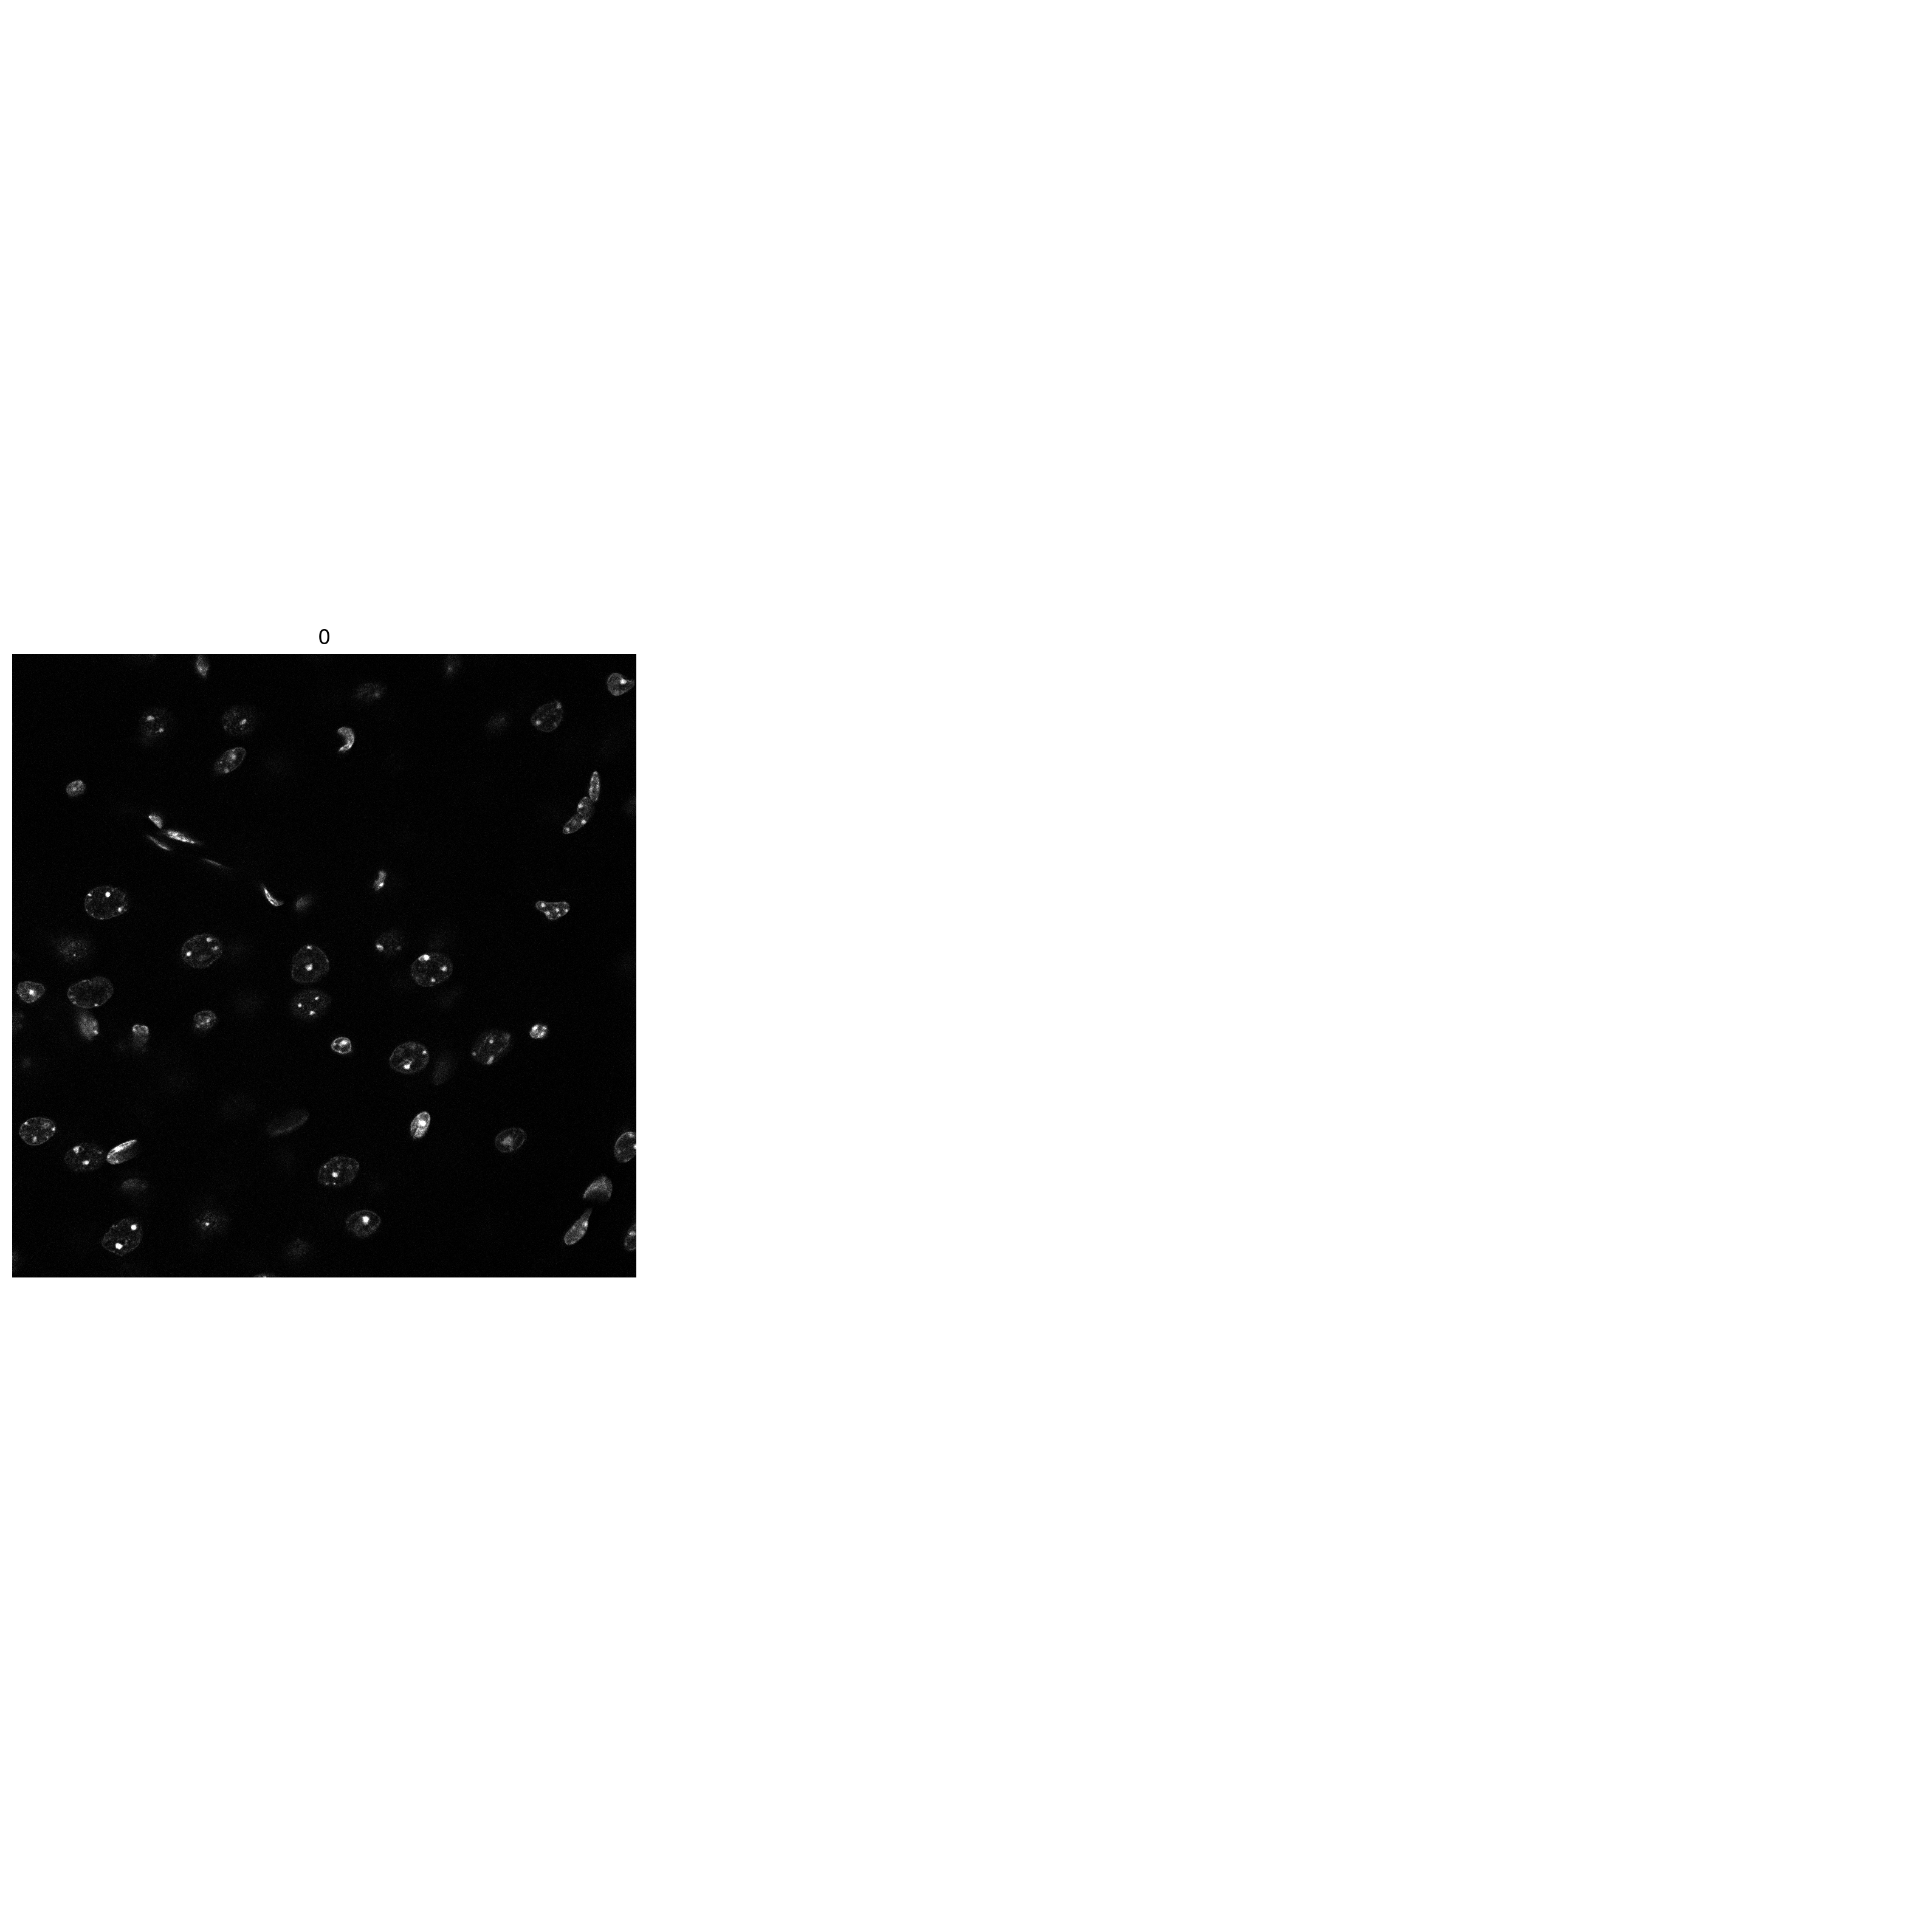

In [10]:
#Running
S = sorted(glob('data/ctx_dapi/test/images/*DAPI.tif'))# file name needed
print(S)
X = list(map(imread,S))

root = "./data/ctx_dapi/test/result/"
if not os.path.exists(root):
    os.mkdir(root)

model = StarDist3D(None, name="stardist", basedir="models")

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

# show all test images
if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [20]:
for i in range(len(X)):
    l, c = divide_and_reconstract(model, X[i], great_number=1000,overlap_size=50)
    cen1 = np.zeros(l.shape)
    root = S[i].replace("images", "result")  # output dir needed
    print(root)
    root = root.replace(".tif", "_predict.tif")
    print(root)
    l = l.astype(np.uint16)
    io.imsave(root, l)
    root_point = root.replace("tif", "txt")
    with open(root_point, "w") as f:
        for line in c:
            cen1[line[0], line[1], line[2]] = 65535
            f.write(str(line[0]) + "," + str(line[1]) + "," + str(line[2]) + "\n")

    cen1 = skimage.morphology.dilation(cen1, skimage.morphology.ball(5))
    cen1 = cen1.astype(np.uint16)
    io.imsave(root.replace("predict", "centroid"), cen1)

3 3
391 391
341 341
1/1 [==============================] - 0s 100ms/step


2187173354.py (107): ./data/ctx_dapi/test/images/temp0.tif is a low contrast image


y_st 342
1/1 [==============================] - 0s 86ms/step


2187173354.py (107): ./data/ctx_dapi/test/images/temp1.tif is a low contrast image


ValueError: could not broadcast input array from shape (181,391,366) into shape (181,391,391)